In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import torch
from einops import rearrange, repeat
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

from utils import (
    permute_image,
    topk_acc,
    invert_permutation,
    hungarian_refine,
    visualize_errors,
)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [19]:
vit_trainer = VitTrainer.load_from_checkpoint('logs/kf2x907t-484-ep78.ckpt')
cfg = vit_trainer.cfg

vit = vit_trainer.model.to(device)
vit = vit.eval()
dataset = ImageDataset(cfg.data_dir, cfg.image_paths_pkl)

Selected index: 39549


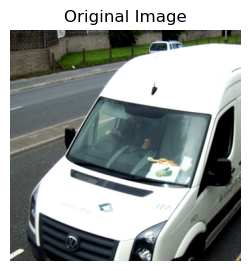

In [20]:
# idx = randint(0, len(dataset) - 1)
# idx = 50398  # easy car
# idx = 133863  # difficult, degenerate example with large black background
# idx = 90186 # almost uniform texture
# idx = 153060  # large white sky
idx = 39549  # overexposed van
print(f'Selected index: {idx}')
orig_image = vit_trainer.resize_image(dataset[idx])

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title('Original Image')
ax.axis('off')
ax.imshow(orig_image.permute(1, 2, 0))
plt.show()

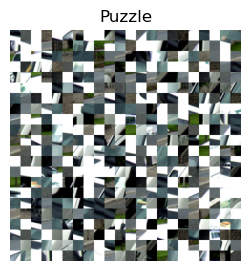

In [21]:
perm_image, perm = permute_image(orig_image.clone(), patch_size=cfg.patch_size)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title('Puzzle')
ax.axis('off')
ax.imshow(perm_image.permute(1, 2, 0))
plt.show()

In [22]:
with torch.inference_mode():
    x = perm_image.unsqueeze(0).to(device)
    x = vit_trainer.norm_image(x)
    pred_perm_logits = vit(x)
    pred_perm = pred_perm_logits.squeeze().argmax(dim=-1)

In [23]:
gt = vit_trainer.gt_single[:, perm].expand(pred_perm_logits.size(0), -1)
gt_perm = gt.squeeze()
t1_acc = topk_acc(pred_perm_logits, gt, k=1)
t5_acc = topk_acc(pred_perm_logits, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.8698
Top-5 accuracy: 0.8905


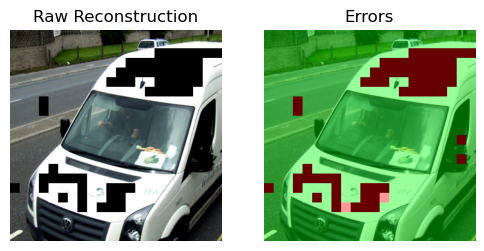

In [26]:
inv_perm = invert_permutation(pred_perm, allow_degenerate=True)
recon_image, _ = permute_image(
    perm_image.clone(), cfg.patch_size, inv_perm, allow_degenerate=True
)

err = visualize_errors(recon_image, cfg.patch_size, pred_perm, gt_perm, alpha=0.4)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(6, 3))
a1.set_title('Raw Reconstruction')
a1.axis('off')
a1.imshow(recon_image.permute(1, 2, 0))
a2.set_title('Errors')
a2.axis('off')
a2.imshow(err)
plt.show()

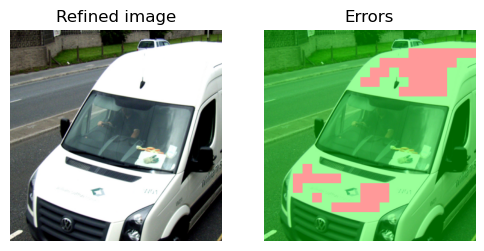

In [27]:
refined_pred_perm = hungarian_refine(pred_perm_logits.squeeze())
refined_inv_perm = invert_permutation(refined_pred_perm)
refined_recon_image, _ = permute_image(perm_image, cfg.patch_size, refined_inv_perm)
refined_err_image = visualize_errors(
    refined_recon_image, cfg.patch_size, refined_pred_perm, gt_perm
)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(6, 3))
a1.set_title('Refined image')
a1.imshow(refined_recon_image.permute(1, 2, 0))
a1.axis('off')
a2.set_title('Errors')
a2.imshow(refined_err_image)
a2.axis('off')
plt.show()